In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from pyDOE import lhs
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

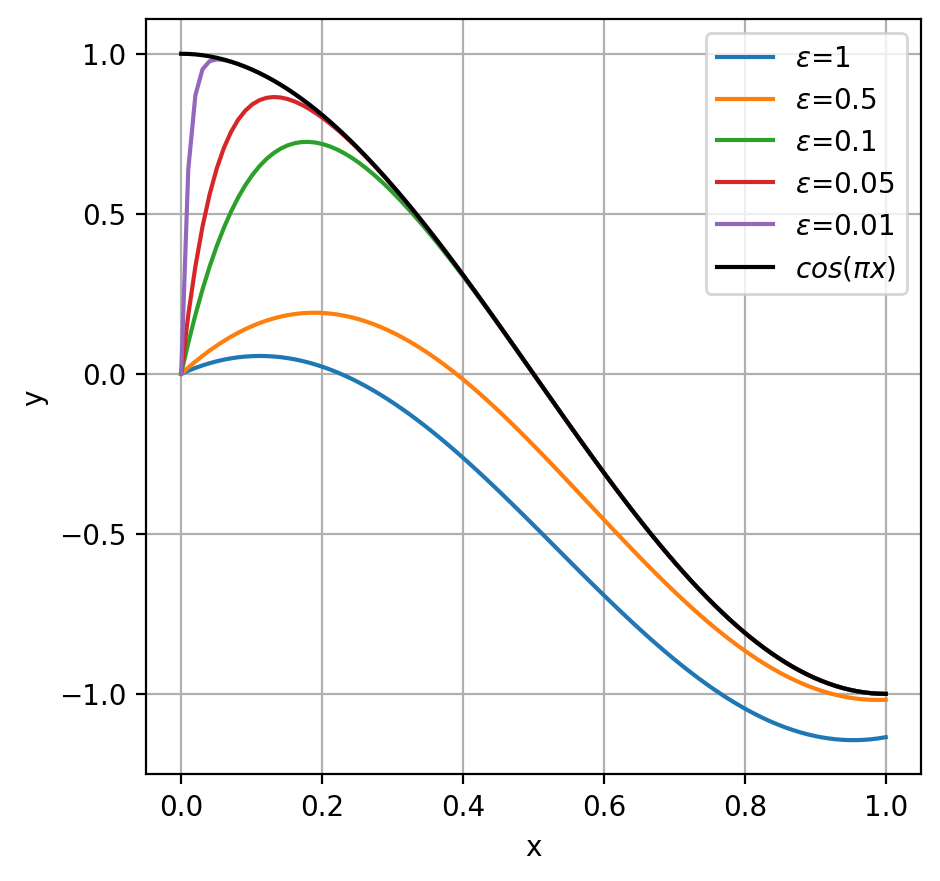

In [2]:
x = np.linspace(0,1,100)
x = np.array([x]).T

def solution(x,e):
    return -np.exp(-(x*x+x)/e) + np.cos(np.pi*x)

plt.figure(figsize=(5,5),dpi=200)
plt.plot(x,solution(x,1),label='$\epsilon$=1')
plt.plot(x,solution(x,0.5),label='$\epsilon$=0.5')
plt.plot(x,solution(x,0.1),label='$\epsilon$=0.1')
plt.plot(x,solution(x,0.05),label='$\epsilon$=0.05')
plt.plot(x,solution(x,0.01),label='$\epsilon$=0.01')
plt.plot(x,np.cos(np.pi*x),label='$cos(\pi x)$',c='k')
plt.legend()
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('D:\\paper_tpinn\\fig_TPINN\\secondorder1_1.png')
plt.show()

e = 0.01
y = solution(x,e)
x_i = np.array([[0]],dtype='float')
y_i = np.array([[0],[1/e]],dtype='float')
x_f = lhs(1, 10000)
x_i = tf.constant(x_i,dtype=tf.float32)
x_f = tf.constant(x_f,dtype=tf.float32)
y_i = tf.constant(y_i,dtype=tf.float32)
x = tf.constant(x,dtype=tf.float32)
y = tf.constant(y,dtype=tf.float32)

In [3]:
def new_PINN(model,index_1,index_2):
    shapes = tf.shape_n(model.trainable_variables)
    n_tensors = len(shapes)
    count = 0
    idx = []
    part = []
    for i, shape in enumerate(shapes):
        n = np.product(shape)
        idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
        part.extend([i]*n)
        count += n
    part = tf.constant(part)
    pinn_params_last_index = idx[-1].numpy()[0]
    
    index_1_shapes = tf.shape_n(index_1.trainable_variables)
    index_1_n_tensors = len(index_1_shapes)
    index_1_count = 0
    index_1_idx = []
    index_1_part = []
    for i, shape in enumerate(index_1_shapes):
        n = np.product(shape)
        index_1_idx.append(tf.reshape(tf.range(index_1_count, index_1_count+n, dtype=tf.int32), shape))
        index_1_part.extend([i]*n)
        index_1_count += n
    index_1_part = tf.constant(index_1_part)
    
    index_2_shapes = tf.shape_n(index_2.trainable_variables)
    index_2_n_tensors = len(index_2_shapes)
    index_2_count = 0
    index_2_idx = []
    index_2_part = []
    for i, shape in enumerate(index_2_shapes):
        n = np.product(shape)
        index_2_idx.append(tf.reshape(tf.range(index_2_count, index_2_count+n, dtype=tf.int32), shape))
        index_2_part.extend([i]*n)
        index_2_count += n
    index_2_part = tf.constant(index_2_part)
    
    index_1_params_last_index = index_1_idx[-1].numpy()[0]
    index_2_params_last_index = index_2_idx[-1].numpy()[0]

    @tf.function
    def assign_new_model_parameters(pinn_params_1d):
        params = tf.dynamic_partition(pinn_params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))
    
    @tf.function
    def assign_new_index_1_parameters(index_1_params_1d):
        params = tf.dynamic_partition(index_1_params_1d, index_1_part, index_1_n_tensors)
        for i, (shape, param) in enumerate(zip(index_1_shapes, params)):
            index_1.trainable_variables[i].assign(tf.reshape(param, shape))
    
    @tf.function
    def assign_new_index_2_parameters(index_2_params_1d):
        params = tf.dynamic_partition(index_2_params_1d, index_2_part, index_2_n_tensors)
        for i, (shape, param) in enumerate(zip(index_2_shapes, params)):
            index_2.trainable_variables[i].assign(tf.reshape(param, shape))
    
    @tf.function
    def f(params_1d):
        c2 = tf.reshape(params_1d[-2],(1,))
        c1 = tf.reshape(params_1d[-1],(1,))
        pinn_params_1d = params_1d[:pinn_params_last_index+1]
        index_1_params_1d = params_1d[pinn_params_last_index+1:pinn_params_last_index+index_1_params_last_index+2]
        index_2_params_1d = params_1d[pinn_params_last_index+index_1_params_last_index+2:pinn_params_last_index+index_1_params_last_index+index_2_params_last_index+3]
        with tf.GradientTape() as tape:
            tape.watch([model.trainable_variables,index_1.trainable_variables,index_2.trainable_variables,c2,c1])
            assign_new_model_parameters(pinn_params_1d)
            assign_new_index_1_parameters(index_1_params_1d)
            assign_new_index_2_parameters(index_2_params_1d)
            loss_value = Loss_new_PINN(model,index_1,index_2,c1,c2)
        grads = tape.gradient(loss_value, [model.trainable_variables,index_1.trainable_variables,index_2.trainable_variables,c2,c1])
        pinn_grads = tf.dynamic_stitch(idx, grads[0])
        index_1_grads = tf.dynamic_stitch(index_1_idx, grads[1])
        index_2_grads = tf.dynamic_stitch(index_2_idx, grads[2])
        newgrads = tf.concat([pinn_grads,index_1_grads,index_2_grads,grads[3],grads[4]],0)
        f.iter.assign_add(1)
        tf.print("Iter:", f.iter, "loss:", loss_value)
        tf.py_function(f.history.append, inp=[loss_value], Tout=[])
        return loss_value, newgrads
    
    f.iter = tf.Variable(0)
    f.idx = idx
    f.part = part
    f.shapes = shapes
    f.assign_new_model_parameters = assign_new_model_parameters
    
    f.index_1_idx = index_1_idx
    f.index_1_part = index_1_part
    f.index_1_shapes = index_1_shapes
    f.assign_new_index_1_parameters = assign_new_index_1_parameters
    
    f.index_2_idx = index_2_idx
    f.index_2_part = index_2_part
    f.index_2_shapes = index_2_shapes
    f.assign_new_index_2_parameters = assign_new_index_2_parameters
    
    f.history = []

    return f

def Loss_new_PINN(model,index_1,index_2,c1,c2):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x_f,x_i])
        y_pred_f = model.call(x_f)
        y_pred_i = model.call(x_i)
        
        y_pred_f += c1*tf.exp(index_1.call((x_f-1)/e)) + c2*tf.exp(index_2.call(-x_f/e))
        y_pred_i += c1*tf.exp(index_1.call((x_i-1)/e)) + c2*tf.exp(index_2.call(-x_i/e))
        
        y_x = tape.gradient(y_pred_f,x_f)
        y_xx = tape.gradient(y_x,x_f)
        y_x_i = tape.gradient(y_pred_i,x_i)
    del tape
    
    F = e*y_xx + (2*x_f+1)*y_x + 2*y_pred_f + (2*x_f+1)*np.pi*tf.sin(np.pi*x_f) + (e*np.pi**2-2)*tf.cos(np.pi*x_f)
    
    loss = tf.reduce_mean(tf.square(y_i[0]-y_pred_i)) + tf.reduce_mean(tf.square(y_i[1]-y_x_i)) + tf.reduce_mean(tf.square(F))
    return loss


def Loss_PINN(model):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x_f,x_i])
        y_pred_f = model.call(x_f)
        y_pred_i = model.call(x_i)
        
        y_x = tape.gradient(y_pred_f,x_f)
        y_xx = tape.gradient(y_x,x_f)
        y_x_i = tape.gradient(y_pred_i,x_i)
    del tape
    
    F = e*y_xx + (2*x_f+1)*y_x + 2*y_pred_f + (2*x_f+1)*np.pi*tf.sin(np.pi*x_f) + (e*np.pi**2-2)*tf.cos(np.pi*x_f)
    
    loss = tf.reduce_mean(tf.square(y_i[0]-y_pred_i)) + tf.reduce_mean(tf.square(y_i[1]-y_x_i)) + tf.reduce_mean(tf.square(F))
    return loss

def PINN(model):
    shapes = tf.shape_n(model.trainable_variables)
    n_tensors = len(shapes)
    count = 0
    idx = []
    part = []
    for i, shape in enumerate(shapes):
        n = np.product(shape)
        idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
        part.extend([i]*n)
        count += n
    part = tf.constant(part)

    @tf.function
    def assign_new_model_parameters(params_1d):
        params = tf.dynamic_partition(params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))

    @tf.function
    def f(params_1d):
        with tf.GradientTape() as tape:
            tape.watch(model.trainable_variables)
            assign_new_model_parameters(params_1d)
            loss_value = Loss_PINN(model)
        grads = tape.gradient(loss_value, model.trainable_variables)
        newgrads = tf.dynamic_stitch(idx, grads)
        f.iter.assign_add(1)
        tf.print("Iter:", f.iter, "loss:", loss_value)
        tf.py_function(f.history.append, inp=[loss_value], Tout=[])
        return loss_value, newgrads
    
    f.iter = tf.Variable(0)
    f.idx = idx
    f.part = part
    f.shapes = shapes
    f.assign_new_model_parameters = assign_new_model_parameters
    f.history = []

    return f


model = keras.models.Sequential([
    keras.layers.Dense(2, activation='tanh'),
    keras.layers.Dense(10, activation='tanh'),
    keras.layers.Dense(1)
])
model.call(x_f)

index_1 = keras.models.Sequential([
    keras.layers.Dense(2, activation='tanh'),
    keras.layers.Dense(10, activation='tanh'),
    keras.layers.Dense(1)
])
index_1.call(x_f)

index_2 = keras.models.Sequential([
    keras.layers.Dense(2, activation='tanh'),
    keras.layers.Dense(10, activation='tanh'),
    keras.layers.Dense(1)
])
index_2.call(x_f)

model_pinn = keras.models.Sequential([
    keras.layers.Dense(2, activation='tanh'),
    keras.layers.Dense(10, activation='tanh'),
    keras.layers.Dense(1)
])
model_pinn.call(x_f)


newpinn = new_PINN(model,index_1,index_2)
ic1 = tf.Variable([0.])
ic2 = tf.Variable([0.])
init_pinn_params = tf.dynamic_stitch(newpinn.idx, model.trainable_variables)
init_index_1_params = tf.dynamic_stitch(newpinn.index_1_idx, index_1.trainable_variables)
init_index_2_params = tf.dynamic_stitch(newpinn.index_2_idx, index_2.trainable_variables)
params = tf.concat([init_pinn_params,init_index_1_params,init_index_2_params,ic2,ic1],0)
final_params = tfp.optimizer.lbfgs_minimize(value_and_gradients_function=newpinn, initial_position=params, max_iterations=1000)

pinn = PINN(model_pinn)
#init_pinn_params = tf.dynamic_stitch(pinn.idx, model_pinn.trainable_variables)
final_pinn_params = tfp.optimizer.lbfgs_minimize(value_and_gradients_function=pinn, initial_position=init_pinn_params, max_iterations=1000)

c1_pred = final_params.position[-1].numpy()
c2_pred = final_params.position[-2].numpy()

pred = model.predict(x) + c1_pred*tf.exp(index_1.predict((x-1)/e)) + c2_pred*tf.exp(index_2.predict(-x/e))
res = y - pred
pinn_pred = model_pinn.predict(x)
res_pinn = y - pinn_pred

Iter: 1 loss: 9930.04883
Iter: 2 loss: 8.76386779e+11
Iter: 3 loss: 387.935059
Iter: 4 loss: 63066.7383
Iter: 5 loss: 374.112274
Iter: 6 loss: 342.311615
Iter: 7 loss: 898.39386
Iter: 8 loss: 342.266571
Iter: 9 loss: 335.334961
Iter: 10 loss: 308.871
Iter: 11 loss: 237.297852
Iter: 12 loss: 237.226074
Iter: 13 loss: 209.40036
Iter: 14 loss: 209.231781
Iter: 15 loss: 149.492554
Iter: 16 loss: 144.995163
Iter: 17 loss: 40875.8125
Iter: 18 loss: 138.040009
Iter: 19 loss: 2406.75928
Iter: 20 loss: 65070.3477
Iter: 21 loss: 23922.0312
Iter: 22 loss: 126.368881
Iter: 23 loss: 524.807434
Iter: 24 loss: 101.984009
Iter: 25 loss: 362.561798
Iter: 26 loss: 91.3416901
Iter: 27 loss: 96.561264
Iter: 28 loss: 83.4703903
Iter: 29 loss: 82.6899109
Iter: 30 loss: 82.4381714
Iter: 31 loss: 82.3844223
Iter: 32 loss: 82.275444
Iter: 33 loss: 85.0813141
Iter: 34 loss: 82.2745
Iter: 35 loss: 81.9633484
Iter: 36 loss: 80.8079605
Iter: 37 loss: 78.5082092
Iter: 38 loss: 78.3447266
Iter: 39 loss: 73.3578262
I

Iter: 295 loss: 0.49454689
Iter: 296 loss: 0.866184533
Iter: 297 loss: 0.483287603
Iter: 298 loss: 0.563305
Iter: 299 loss: 0.465973884
Iter: 300 loss: 0.465887696
Iter: 301 loss: 0.448591948
Iter: 302 loss: 0.438516378
Iter: 303 loss: 0.625978589
Iter: 304 loss: 0.438305706
Iter: 305 loss: 0.43128106
Iter: 306 loss: 0.509577274
Iter: 307 loss: 0.43111223
Iter: 308 loss: 0.423229307
Iter: 309 loss: 0.46755898
Iter: 310 loss: 0.42155683
Iter: 311 loss: 0.42027694
Iter: 312 loss: 0.419543862
Iter: 313 loss: 0.419471204
Iter: 314 loss: 0.41778788
Iter: 315 loss: 0.410069108
Iter: 316 loss: 0.395780087
Iter: 317 loss: 0.395415187
Iter: 318 loss: 0.352500021
Iter: 319 loss: 2.7462132
Iter: 320 loss: 0.352409095
Iter: 321 loss: 0.356352359
Iter: 322 loss: 0.330725551
Iter: 323 loss: 0.322629452
Iter: 324 loss: 0.424734294
Iter: 325 loss: 0.321718752
Iter: 326 loss: 0.312491447
Iter: 327 loss: 0.927682638
Iter: 328 loss: 0.312492192
Iter: 329 loss: 0.294279158
Iter: 330 loss: 0.340361476
Iter

Iter: 590 loss: 0.0850634426
Iter: 591 loss: 0.0847256333
Iter: 592 loss: 0.0802700073
Iter: 593 loss: 0.139383584
Iter: 594 loss: 0.080266729
Iter: 595 loss: 0.0788612738
Iter: 596 loss: 0.0770512149
Iter: 597 loss: 0.0756221041
Iter: 598 loss: 0.0747764707
Iter: 599 loss: 0.0750331134
Iter: 600 loss: 0.0741866082
Iter: 601 loss: 0.0729300752
Iter: 602 loss: 0.0771137178
Iter: 603 loss: 0.0724506229
Iter: 604 loss: 0.0949999392
Iter: 605 loss: 0.0721869767
Iter: 606 loss: 0.0706458911
Iter: 607 loss: 0.0706003755
Iter: 608 loss: 0.0701773614
Iter: 609 loss: 0.0700659156
Iter: 610 loss: 0.0696529448
Iter: 611 loss: 0.0742241442
Iter: 612 loss: 0.0696370304
Iter: 613 loss: 0.0691074654
Iter: 614 loss: 0.0727484152
Iter: 615 loss: 0.0690291151
Iter: 616 loss: 0.068816
Iter: 617 loss: 0.068813704
Iter: 618 loss: 0.0684839934
Iter: 619 loss: 0.0772100165
Iter: 620 loss: 0.0684741884
Iter: 621 loss: 0.0682361424
Iter: 622 loss: 0.0732330903
Iter: 623 loss: 0.0682304651
Iter: 624 loss: 0.067

Iter: 3 loss: 9929.9873
Iter: 4 loss: 44268608
Iter: 5 loss: 9924.50684
Iter: 6 loss: 3394922.75
Iter: 7 loss: 9882.7334
Iter: 8 loss: 246893.391
Iter: 9 loss: 9737.3291
Iter: 10 loss: 31462.0215
Iter: 11 loss: 8855.66895
Iter: 12 loss: 6287.53516
Iter: 13 loss: 5689.32568
Iter: 14 loss: 4598.22266
Iter: 15 loss: 49705.4
Iter: 16 loss: 4535.48389
Iter: 17 loss: 3132.52026
Iter: 18 loss: 13090.6035
Iter: 19 loss: 2443.00073
Iter: 20 loss: 1910.45312
Iter: 21 loss: 2336.46582
Iter: 22 loss: 1726.20642
Iter: 23 loss: 8032.13916
Iter: 24 loss: 4729.20215
Iter: 25 loss: 1234.69543
Iter: 26 loss: 1077.75696
Iter: 27 loss: 1071.05066
Iter: 28 loss: 1016.42969
Iter: 29 loss: 837.011719
Iter: 30 loss: 4183.02148
Iter: 31 loss: 780.123779
Iter: 32 loss: 794.541
Iter: 33 loss: 699.857056
Iter: 34 loss: 561.921814
Iter: 35 loss: 554.048889
Iter: 36 loss: 420.104675
Iter: 37 loss: 991.344177
Iter: 38 loss: 413.588074
Iter: 39 loss: 1505.25391
Iter: 40 loss: 358.957092
Iter: 41 loss: 6593.61621
Iter

Iter: 313 loss: 15.0811653
Iter: 314 loss: 15.081152
Iter: 315 loss: 15.0812016
Iter: 316 loss: 15.0811491
Iter: 317 loss: 15.0811234
Iter: 318 loss: 15.0811234
Iter: 319 loss: 15.0811081
Iter: 320 loss: 15.0811501
Iter: 321 loss: 15.0811043
Iter: 322 loss: 15.2037926
Iter: 323 loss: 15.0810957
Iter: 324 loss: 15.0810528
Iter: 325 loss: 15.0810547
Iter: 326 loss: 15.080987
Iter: 327 loss: 15.0809479
Iter: 328 loss: 15.0812616
Iter: 329 loss: 15.0809441
Iter: 330 loss: 15.0809155
Iter: 331 loss: 15.0808992
Iter: 332 loss: 15.0808372
Iter: 333 loss: 15.0833473
Iter: 334 loss: 15.0808353
Iter: 335 loss: 15.0807905
Iter: 336 loss: 15.0806828
Iter: 337 loss: 15.0806952
Iter: 338 loss: 15.0817146
Iter: 339 loss: 15.0806923
Iter: 340 loss: 15.0807133
Iter: 341 loss: 15.0806694
Iter: 342 loss: 15.0807362
Iter: 343 loss: 15.0806522
Iter: 344 loss: 15.0806389
Iter: 345 loss: 15.0806293
Iter: 346 loss: 15.0805893
Iter: 347 loss: 15.0829163
Iter: 348 loss: 15.0805893
Iter: 349 loss: 15.0805607
Ite

Iter: 619 loss: 15.0634499
Iter: 620 loss: 15.0646038
Iter: 621 loss: 15.0634079
Iter: 622 loss: 15.0633364
Iter: 623 loss: 15.0633163
Iter: 624 loss: 15.0629959
Iter: 625 loss: 15.0629959
Iter: 626 loss: 15.0629377
Iter: 627 loss: 15.0628777
Iter: 628 loss: 15.0627079
Iter: 629 loss: 15.0768881
Iter: 630 loss: 15.0627079
Iter: 631 loss: 15.0627041
Iter: 632 loss: 15.0626469
Iter: 633 loss: 15.0624723
Iter: 634 loss: 15.0658
Iter: 635 loss: 15.0624523
Iter: 636 loss: 15.0623322
Iter: 637 loss: 15.06213
Iter: 638 loss: 15.1466503
Iter: 639 loss: 15.0621281
Iter: 640 loss: 15.9267311
Iter: 641 loss: 15.0621243
Iter: 642 loss: 15.0629511
Iter: 643 loss: 15.0620623
Iter: 644 loss: 15.0627861
Iter: 645 loss: 15.062005
Iter: 646 loss: 15.0622368
Iter: 647 loss: 15.0619516
Iter: 648 loss: 15.0618935
Iter: 649 loss: 15.0618916
Iter: 650 loss: 15.0618572
Iter: 651 loss: 15.0620966
Iter: 652 loss: 15.0618601
Iter: 653 loss: 15.0618362
Iter: 654 loss: 15.0618277
Iter: 655 loss: 15.0618019
Iter: 6

Iter: 925 loss: 15.0506039
Iter: 926 loss: 15.0556545
Iter: 927 loss: 15.0506039
Iter: 928 loss: 15.0504503
Iter: 929 loss: 15.0503073
Iter: 930 loss: 15.0502682
Iter: 931 loss: 15.0502701
Iter: 932 loss: 15.0501919
Iter: 933 loss: 15.0524416
Iter: 934 loss: 15.0501528
Iter: 935 loss: 15.0500889
Iter: 936 loss: 15.0500422
Iter: 937 loss: 15.0883751
Iter: 938 loss: 15.0500374
Iter: 939 loss: 15.05056
Iter: 940 loss: 15.0500069
Iter: 941 loss: 15.0500031
Iter: 942 loss: 15.0499668
Iter: 943 loss: 15.0499325
Iter: 944 loss: 15.0511074
Iter: 945 loss: 15.0499306
Iter: 946 loss: 15.0498848
Iter: 947 loss: 15.0498
Iter: 948 loss: 15.0548649
Iter: 949 loss: 15.049799
Iter: 950 loss: 15.0497265
Iter: 951 loss: 15.0501442
Iter: 952 loss: 15.0497046
Iter: 953 loss: 15.0497093
Iter: 954 loss: 15.0496788
Iter: 955 loss: 15.0496483
Iter: 956 loss: 15.0496206
Iter: 957 loss: 15.0515604
Iter: 958 loss: 15.0495892
Iter: 959 loss: 15.0495129
Iter: 960 loss: 15.0506182
Iter: 961 loss: 15.0495148
Iter: 9

Iter: 1222 loss: 15.0443439
Iter: 1223 loss: 15.0442867
Iter: 1224 loss: 15.0447216
Iter: 1225 loss: 15.0442924
Iter: 1226 loss: 15.0456581
Iter: 1227 loss: 15.0442715
Iter: 1228 loss: 15.044548
Iter: 1229 loss: 15.0442524
Iter: 1230 loss: 15.0448093
Iter: 1231 loss: 15.0442362
Iter: 1232 loss: 15.0443153
Iter: 1233 loss: 15.0441885
Iter: 1234 loss: 15.0441504
Iter: 1235 loss: 15.0441437
Iter: 1236 loss: 15.0441284
Iter: 1237 loss: 15.0443535
Iter: 1238 loss: 15.0441265
Iter: 1239 loss: 15.0440826
Iter: 1240 loss: 15.0445652
Iter: 1241 loss: 15.0440722
Iter: 1242 loss: 15.0440197
Iter: 1243 loss: 15.0440187
Iter: 1244 loss: 15.0439701
Iter: 1245 loss: 15.0439739
Iter: 1246 loss: 15.0439301
Iter: 1247 loss: 15.04669
Iter: 1248 loss: 15.0439386
Iter: 1249 loss: 15.0439138
Iter: 1250 loss: 15.0442896
Iter: 1251 loss: 15.0439091
Iter: 1252 loss: 15.0439129
Iter: 1253 loss: 15.0438843
Iter: 1254 loss: 15.2552338
Iter: 1255 loss: 15.0438862
Iter: 1256 loss: 15.0438499
Iter: 1257 loss: 15.043

Iter: 1516 loss: 15.0384769
Iter: 1517 loss: 15.0384655
Iter: 1518 loss: 15.0384245
Iter: 1519 loss: 15.0390453
Iter: 1520 loss: 15.0384245
Iter: 1521 loss: 15.0383816
Iter: 1522 loss: 15.0383778
Iter: 1523 loss: 15.038312
Iter: 1524 loss: 15.039999
Iter: 1525 loss: 15.0383091
Iter: 1526 loss: 15.0382118
Iter: 1527 loss: 15.0385895
Iter: 1528 loss: 15.0382118
Iter: 1529 loss: 15.0383511
Iter: 1530 loss: 15.0381699
Iter: 1531 loss: 15.0384884
Iter: 1532 loss: 15.0381279
Iter: 1533 loss: 15.0381088
Iter: 1534 loss: 15.0380726
Iter: 1535 loss: 15.0380344
Iter: 1536 loss: 15.0380383
Iter: 1537 loss: 15.0380135
Iter: 1538 loss: 15.0380154
Iter: 1539 loss: 15.0379534
Iter: 1540 loss: 15.0379782
Iter: 1541 loss: 15.0378971
Iter: 1542 loss: 15.0378208
Iter: 1543 loss: 15.0378189
Iter: 1544 loss: 15.0378189
Iter: 1545 loss: 15.0377798
Iter: 1546 loss: 15.0378704
Iter: 1547 loss: 15.0377541
Iter: 1548 loss: 15.0377407
Iter: 1549 loss: 15.0377312
Iter: 1550 loss: 15.0377197
Iter: 1551 loss: 15.03

epsilon = 0.01
c1,c2 = -1.8241997 0.36598334


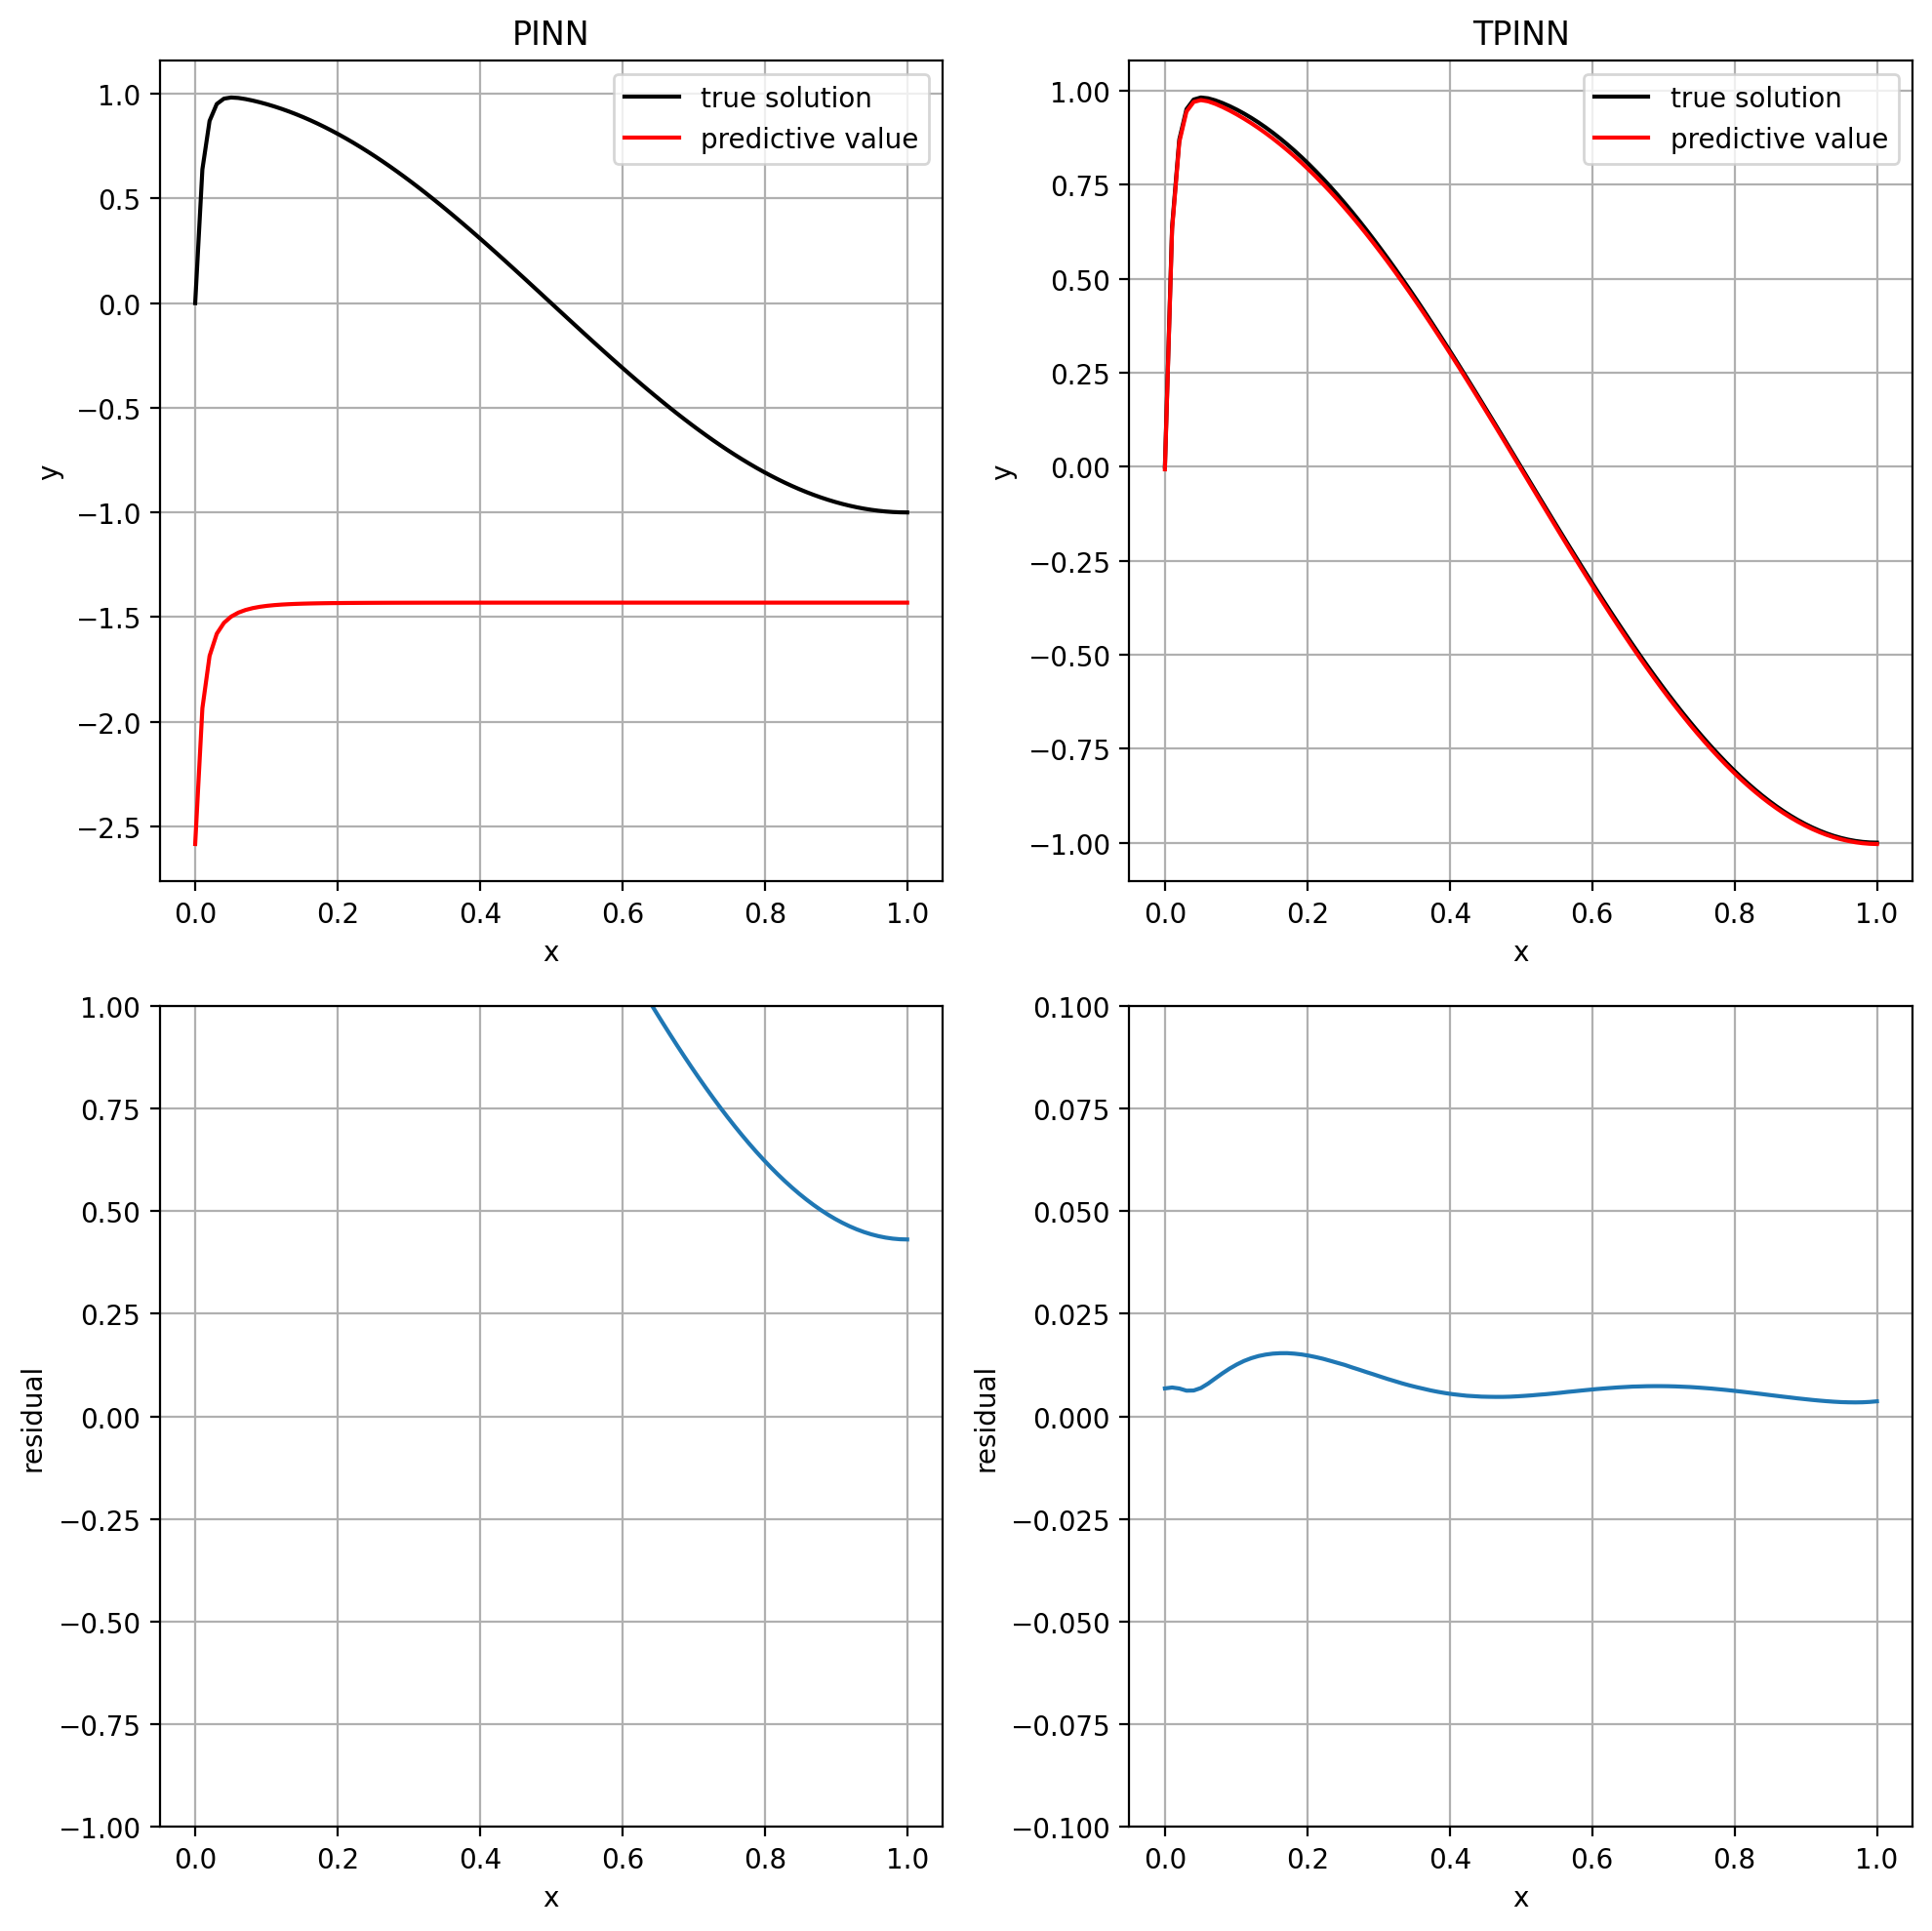

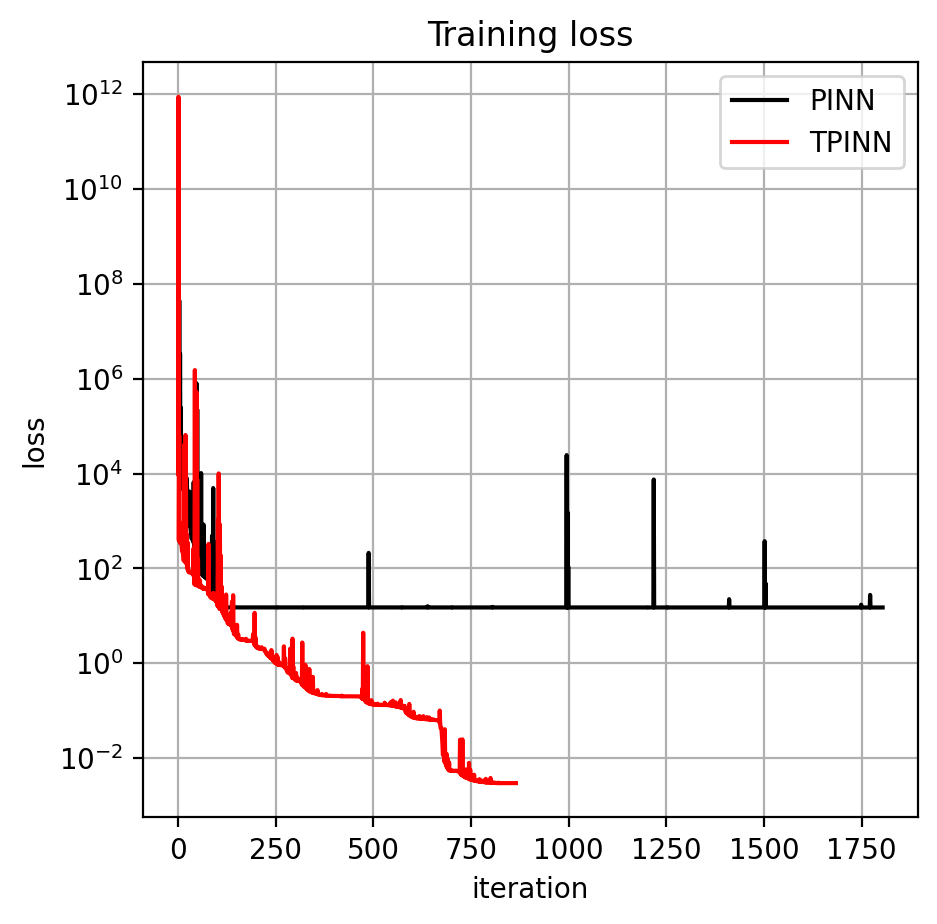

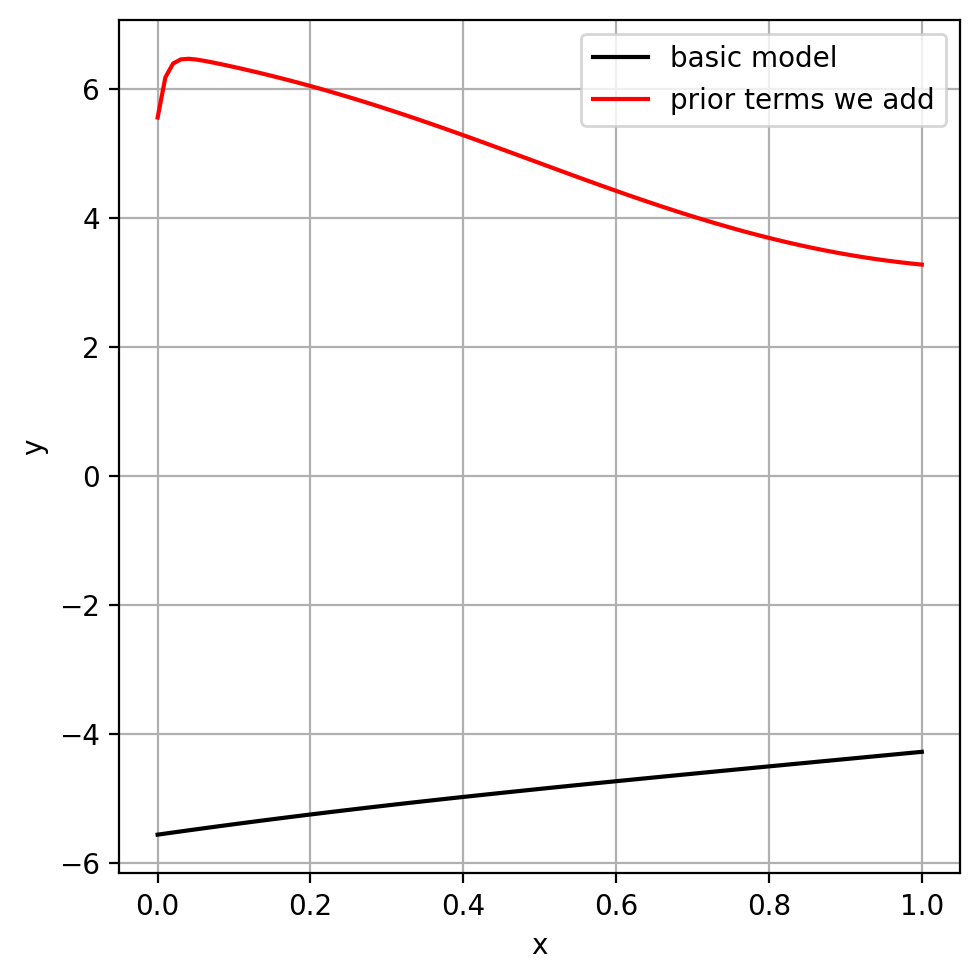

In [4]:
print('epsilon =',e)
print('c1,c2 =',c1_pred,c2_pred)

plt.figure(figsize=(10,10),dpi=200)
plt.subplot(2,2,1)
plt.title('PINN')
plt.plot(x,y,color='k',label='true solution')
plt.plot(x,pinn_pred,color='r',label='predictive value')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.subplot(2,2,2)
plt.title('TPINN')
plt.plot(x,y,color='k',label='true solution')
plt.plot(x,pred,color='r',label='predictive value')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.subplot(2,2,3)
plt.plot(x,res_pinn)
plt.ylim((-1,1))
plt.xlabel('x')
plt.ylabel('residual')
plt.grid()
plt.subplot(2,2,4)
plt.plot(x,res)
plt.ylim((-0.1,0.1))
plt.xlabel('x')
plt.ylabel('residual')
plt.grid()
plt.tight_layout()
plt.savefig('D:\\paper_tpinn\\fig_TPINN\\secondorder1_2.png')
plt.show()

plt.figure(figsize=(5,5),dpi=200)
plt.title('Training loss')
plt.plot(pinn.history,color='k',label='PINN')
plt.plot(newpinn.history,color='r',label='TPINN')
plt.legend()
plt.xlabel('iteration')
plt.ylabel('loss')
plt.yscale('log')
plt.grid()
plt.savefig('D:\\paper_tpinn\\fig_TPINN\\secondorder1_3.png')
plt.show()

plt.figure(figsize=(5,5),dpi=200)
plt.plot(x,model.predict(x),c='k',label='basic model')
plt.plot(x,c1_pred*tf.exp(index_1.predict((x-1)/e)) + c2_pred*tf.exp(index_2.predict(-x/e)),c='r',label='prior terms we add')
plt.legend()
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.savefig('D:\\paper_tpinn\\fig_TPINN\\secondorder1_4.png')
plt.show()